In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [ ]:
%autosave 0
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
import corner

# A (brief) tutorial on [Pyro](https://pyro.ai/)

Pyro can be used to perform MCMC and/or approximate inference for intractable posteriors

We can use Pyro to move from point estimates to posteriors in our **torch-based model**

In [ ]:
import pyro
display(pyro.__version__)
pyro.set_rng_seed(101)

Let's start by creating a normal distribution

Distributions in Pyro are implemented in [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

The `Normal` object expects location $\mu$ and scale $\sigma$

In [ ]:
from pyro.distributions import Normal

w_prior = Normal(loc=torch.tensor(0.), 
                 scale=torch.tensor(1.))

We can sample from this distribution

In [ ]:
# Get 1000 samples 
samples = w_prior.rsample(sample_shape=(1000, ))
display(samples.shape)
# Build an histogram
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(samples.detach().numpy(), bins=20, density=True)
# Plot the pdf
w_plot = np.linspace(-3, 3, num=100)
w_pdf = torch.exp(w_prior.log_prob(torch.from_numpy(w_plot))).detach().numpy()
plt.plot(w_plot, w_pdf, 'k-', lw=2);

We can compute descriptors

In [ ]:
#mean
display(w_prior.mean)
#standard deviation
display(w_prior.stddev)
#entropy
display(w_prior.entropy())

#### Shape of pyro tensors

A distribution has two shapes

`event_shape` refers to the dimensionality of the distribution, e.g. normal (number), multivariate normal (vector), Cholesky (matrix), etc

> `event_shape` denotes dependent random variables

`batch_shape` refers to a batch of distributions

> `batch_shape` denotes conditionally independent random variables (typically our data dimension)

We can create a batched distribution by batching the parameters

The shape of a sampled tensor will be the sum of event and batch shapes

In [ ]:
# Two conditionally independent normal RVs
w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]]))
# A multivariate normal with diagonal covariance
#w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]])).to_event(1)

display(w_prior.batch_shape)
display(w_prior.event_shape)
display(w_prior.rsample().shape)

## Random variables in Pyro

To create random variables that we can track within a model we use [`pyro.sample`](http://pyro.ai/examples/intro_part_i.html#The-pyro.sample-Primitive)

`sample` expects a name and an object from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

For example, to create a variable named "w" with the previously defined distribution
$$
\begin{align}
w \sim &\mathcal{N}(\mu, \sigma^2) \nonumber \\
&\mu = \begin{pmatrix}0 \\ 2 \end{pmatrix}, \sigma = \begin{pmatrix} 1 \\ 1 \end{pmatrix} \nonumber
\end{align}
$$

In [ ]:
def model():
    return pyro.sample(name='w', fn=w_prior)

Each time we run a model a random sample is returned

In [ ]:
for i in range(10):
    print(model())

### Models and conditioning 

Let's consider a linear regression model

$$
y_i = w x_i + b, \forall i
$$

We will write this model in Pyro 

For this we consider
- $w$ and $b$ to be random variables with normal distributions (priors)
- $y$ to be a random variable with normal distribution (likelihood)
- $x$ to be a deterministic variable
- $y$ is continioned to the observed data $\{y_i\}$


In [ ]:
def model(x):
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0))

def conditioned_model(x, y):
    return pyro.condition(model, data={"y": y})(x)

# or equivalently

def model_obs(x, y=None):  # equivalent to conditioned_scale above
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0), obs=y)

#### Technical details

To create conditions we can use `pyro.condition` or the `obs` keyword of `pyro.sample`

To create conditions on the whole dataset (assuming iid) we use [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate), which expects a name and the size of the dataset

In this case we use `pyro.plate` as a context (vectorized plate), it can also be used as an iterator


#### Theorical details

In summary the model has to define the generative process 

In this case
- Choose hyperparameters: $\mu_w, \sigma_w, \mu_b, \sigma_b, \sigma_\epsilon$
- Sample: $w \sim \mathcal{N}(\mu_w, \sigma_w^2)$
- Sample: $b \sim \mathcal{N}(\mu_b, \sigma_b^2)$
- For each $i=1,2,\ldots, N$
    - Sample: $y_i \sim \mathcal{N}(w x_i + b, \sigma_\epsilon^2)$

This is often summarized using plate notation diagrams

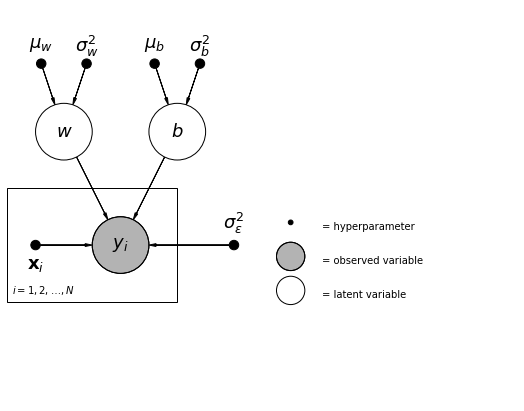

# Inference

Now that we have specified the model we would like to obtain the posterior of the parameters given the data and do predictions

> If we can not solve it analytically or via enumeration we can resort to approximate inference

Pyro offers different ways to perform approximate inference in the module [`pyro.infer`](https://docs.pyro.ai/en/stable/inference.html)

For now we will focus on **Stochastic Variational Inference** 


The unified Variational Inference interface in Pyro is located in [`pyro.infer.SVI`](http://docs.pyro.ai/en/stable/inference_algos.html) 

To use SVI we need to specify
1. A model function that defines our generative model
1. A guide function that defines our approximate posterior
1. A cost function 
1. An optimizer
1. Number of samples to compute Monte-Carlo estimates

### Guide function

> The guide represents our approximate posterior $q_\nu(\theta)$ 

The guide has to define the distribution of the posterior of the parameters 

We use [`pyro.param`]() to register the hyperparameters of the approximate posterior $\eta$

> These parameters are the ones that we learn through optimization

**Technical detail:** The guide function has the same inputs as the model function

In this example we set a normal posterior $\theta=(w, b)$ and create the corresponding hyperparameters $\eta = (\mu_w, \sigma_w, \mu_b, \sigma_b)$

In [ ]:
from torch.distributions import constraints

def guide(x, y=None):
    w_loc = pyro.param("w_loc", torch.tensor(0.))
    w_scale = pyro.param("w_scale", torch.tensor(1.), constraint=constraints.positive)
    w = pyro.sample("w", Normal(w_loc, w_scale))
    b_loc = pyro.param("b_loc", torch.tensor(0.))
    b_scale = pyro.param("b_scale", torch.tensor(1.), constraint=constraints.positive)
    b = pyro.sample("b", Normal(b_loc, b_scale))

### Cost function

In the previous class we studied the Evidence Lower Bound (ELBO)

$$
\begin{align}
\hat \nu &= \text{arg}\max_\nu \mathcal{L}(\nu) \nonumber \\
&= \text{arg}\max_\nu - \int q_\nu(\theta) \log \frac{q_\nu(\theta)}{p(\mathcal{D}|\theta) p (\theta)} d\theta
\end{align}
$$

where
- The model function defines $p(\mathcal{D}|\theta) p (\theta)$ 
- The guide function defines $q_\nu(\theta)$ 

Pyro offers several versions of the [ELBO](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.elbo)

- `Trace_ELBO`: Default ELBO. Reduces variance of the gradients using "Rao-Blackwellization"
- `TraceEnum_ELBO`: Performs exhaustive enumeration for discrete variables
- `TraceMeanField_ELBO`: Assumes Mean-field structure. Reduce variance of gradients using analytical KL when possible

> We will study the importance of gradient variance later

### Training

Once we have defined the model and guide we create an SVI object

In this example we select the default ELBO and SGD with adaptive learning rate optimizer

In [ ]:
pyro.enable_validation(True) #Additional debug of model/guides

pyro.clear_param_store()

svi = pyro.infer.SVI(model=model_obs,  
                     guide=guide,
                     loss=pyro.infer.Trace_ELBO(), # Loss function
                     optim=pyro.optim.ClippedAdam({"lr": 0.01})) # Optimizer

The main method of SVI is 

- `svi.step(*args)`: Performs a gradient step, similar to the `backward()` plus `step()` in pytorch

`step()` receives the inputs for guide and model as arguments

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 2.5), dpi=80, tight_layout=True)
lines = [ax_.plot([], [])[0] for ax_ in ax]
param_names = ["ELBO", "w_loc", "w_scale", "b_loc", "b_scale"]
param_evolution = {}
for name in param_names:
    param_evolution[name] = []
    
for ax_, name in zip(ax, param_names):
    ax_.set_title(name)

In [ ]:
# Observed data
x = torch.tensor([-2., 2.])
y = torch.tensor([-2., 2.])
    
for k in tqdm(range(3000)):
    param_evolution["ELBO"].append(svi.step(x, y))
    for name in param_names[1:]:
        param_evolution[name].append(pyro.param(name).item()) 
    
    if np.mod(k, 100) == 0:
        for i, name in enumerate(param_names):
            lines[i].set_ydata(param_evolution[name][:k])
        for line in lines:
            line.set_xdata(range(k))
        for ax_ in ax.ravel():
            ax_.relim()
            ax_.autoscale_view()
        fig.canvas.draw()

We see that the ELBO and the parameters have converged


## Posterior predictive 

We can evaluate the quality of the trained model by visualizing the posterior of $w$ and $b$ and the posterior predictive of $y$ given $x$


For this we can use the utility class [`pyro.infer.Predictive`](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive)

In [ ]:
line_x = np.linspace(-5, 5, num=100).astype('float32') 

predictive = pyro.infer.Predictive(model_obs, 
                                   guide=guide, 
                                   num_samples=5000,
                                   return_sites=("w", "b", "y"))

samples = predictive(torch.from_numpy(line_x))

# Posterior of w and b
b_plot_vi = samples['b'].detach().numpy()[:, 0]
w_plot_vi = samples['w'].detach().numpy()[:, 0]
figure = corner.corner(np.stack((b_plot_vi, w_plot_vi)).T, 
                       smooth=1., labels=["bias", "weight"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-2, 2), (-1, 3)],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
# Posterior predictive of y given x
y_trace = samples["y"].detach().numpy()
med = np.median(y_trace, axis=0)
qua = np.quantile(y_trace, (0.05, 0.95), axis=0)

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(line_x, med)
ax.fill_between(line_x, qua[0], qua[1], alpha=0.5);

ax.errorbar(2, 2, xerr=0, yerr=2, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2, fmt='none', c='k', zorder=100);

### MCMC with Pyro

[On the MCMC side Pyro](https://docs.pyro.ai/en/stable/mcmc.html) offers Hamiltonian Monte-Carlo and the more recent No-U turn sampler (NUTS)

For theoretical details see Barber Chapter 27 or [here](https://github.com/magister-informatica-uach/INFO337/tree/master/MCMC)

Here we run MCMC as a reference

In [ ]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model_obs, adapt_step_size=True)
sampler = MCMC(nuts_kernel, num_chains=1, num_samples=1000, warmup_steps=1000)
sampler.run(x, y)

Print a summary:

In [ ]:
sampler.summary()

Plot the posteriors

In [ ]:
samples = sampler.get_samples()
w_plot_mcmc = samples['w'].detach().numpy()
b_plot_mcmc = samples['b'].detach().numpy()

figure = corner.corner(np.stack((b_plot_mcmc , w_plot_mcmc )).T, smooth=1.,
                       labels=["b", "w"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-2, 2), (-1, 3)],
                       show_titles=True, title_kwargs={"fontsize": 12})

Not too different from the VI solution

But remember, in this case we used to actual posterior (normal) in the guide

**Most of the time we won't be so lucky**

# Pyro summary

- We create (deterministic) parameters with `pyro.param`
- We create latent random variables using `pyro.sample`
- We create observed random variables using `pyro.sample` with the `obs` keyword

> The model represents our graphical model

> The guide represents our assumptions on the latent variables